N-Body Project

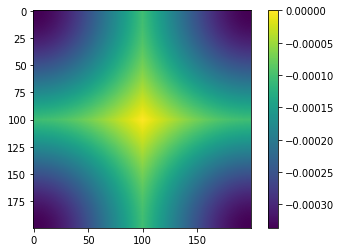

In [485]:
import numpy as np 
from matplotlib import pyplot as plt 
from mpl_toolkits import mplot3d
import math

def greens(n):
    #potential for a single particle in 3D (Green's function of Laplacian)
    dx=np.arange(n)
    dx[n//2:]=dx[n//2:]-n
    xmat,ymat,zmat=np.meshgrid(dx,dx,dx)
    dr=np.sqrt(xmat**2+ymat**2+zmat**2)
    dr[0,0,0]=1 #to avoid errors in pot
    pot=-1/(4*np.pi*dr)
    pot=pot-pot[n//2,n//2,n//2]  #set it so the potential at the edge goes to zero
    # pot[0,0,0]=0
    pot[0,0,0]=pot[1,0,0] #set Laplacian at zero to value of neighbor cell 
    return pot

def convolve_padded(rho,Gft):
    tmp=rho.copy()
    tmp=np.pad(tmp,((0,tmp.shape[0]),)) #padding to avoid errors with FT

    tmpft=np.fft.rfftn(tmp)
    tmp=np.fft.irfftn(tmpft*Gft) #V=rho*G
    tmp=tmp[:rho.shape[0],:rho.shape[1],:rho.shape[2]]
    return tmp #this is now a potential

def positiontorho(pos,m,n,npart):
    #Uses the CIC scheme to get density from softened particle position
    rho=np.zeros([n,n,n])
    #Get particle positions
    if npart==1:
        x=pos[0]
        y=pos[1]
        z=pos[2]
    else:
        x=pos[:,0]
        y=pos[:,1]
        z=pos[:,2]
    #Get particle indices
    i=np.floor(x)
    i=i.astype(int)
    j=np.floor(y)
    j=j.astype(int)
    k=np.floor(z)
    k=k.astype(int)
    #Get center of cell positions
    xc=i+1/2
    yc=j+1/2
    zc=k+1/2
    #Get distance from particle to center of cell
    dx=np.abs(x-xc)
    dy=np.abs(y-yc)
    dz=np.abs(z-zc)
    #Use CIC scheme to 'spread' particle density over neighboring cells
    rho[i,j,k]+=m*(1-dx)*(1-dy)*(1-dz)
    rho[i+1,j,k]+=m*dx*(1-dy)*(1-dz)
    rho[i,j+1,k]+=m*(1-dx)*dy*(1-dz)
    rho[i,j,k+1]+=m*(1-dx)*(1-dy)*dz
    rho[i+1,j+1,k]+=m*dx*dy*(1-dz)
    rho[i,j+1,k+1]+=m*(1-dx)*dy*dz
    rho[i+1,j,k+1]+=m*dx*(1-dy)*dz
    rho[i+1,j+1,k+1]+=m*dx*dy*dz
    return rho


def accel_particle(pot,pos,n,npart):
    #uses CIC scheme to get acceleration of particle
    #pot=np.fft.fftshift(pot)
    ax,ay,az=np.gradient(pot)
    ax=-ax #acceleration= negative gradient/mass (mass=1)
    ay=-ay
    az=-az
    #Same process as for position to density
    if npart==1:
        x=pos[0]
        y=pos[1]
        z=pos[2]
    else:
        x=pos[:,0]
        y=pos[:,1]
        z=pos[:,2]
    i=np.floor(x)
    i=i.astype(int)
    j=np.floor(y)
    j=j.astype(int)
    k=np.floor(z)
    k=k.astype(int)
    xc=i+1/2
    yc=j+1/2
    zc=k+1/2
    dx=np.abs(x-xc)
    dy=np.abs(y-yc)
    dz=np.abs(z-zc)
    tx=1-dx
    ty=1-dy
    tz=1-dz
    #Find accceleration of particle based on acceleration in neighboring cells (CIC Scheme again)
    axp=ax[i,j,k]*tx*ty*tz+ax[i+1,j,k]*dx*ty*tz+ax[i,j+1,k]*tx*dy*tz+ax[i,j,k+1]*tx*ty*dz+ax[i+1,j+1,k]*dx*dy*tz+ax[i+1,j,k+1]*dx*ty*dz+ax[i,j+1,k+1]*tx*dy*dz+ax[i+1,j+1,k+1]*dx*dy*dz
    ayp=ay[i,j,k]*tx*ty*tz+ay[i+1,j,k]*dx*ty*tz+ay[i,j+1,k]*tx*dy*tz+ay[i,j,k+1]*tx*ty*dz+ay[i+1,j+1,k]*dx*dy*tz+ay[i+1,j,k+1]*dx*ty*dz+ay[i,j+1,k+1]*tx*dy*dz+ay[i+1,j+1,k+1]*dx*dy*dz
    azp=az[i,j,k]*tx*ty*tz+az[i+1,j,k]*dx*ty*tz+az[i,j+1,k]*tx*dy*tz+az[i,j,k+1]*tx*ty*dz+az[i+1,j+1,k]*dx*dy*tz+az[i+1,j,k+1]*dx*ty*dz+az[i,j+1,k+1]*tx*dy*dz+az[i+1,j+1,k+1]*dx*dy*dz
    return np.asarray([axp,ayp,azp]).T #transpose this so it has the right orientation

def leapfrog(pos,vel,pot,n,npart,m,dt):
    #Update positions and velocities using the leapfrog method.
    accel=accel_particle(pot,pos,n,npart)
    v_half=vel+0.5*dt*accel
    pos_new=pos+dt*v_half
    rho=positiontorho(pos,m,n,npart)
    accel_new=accel_particle(pot,pos,n,npart)
    vel_new=v_half+0.5*dt*accel_new
    return pos_new,vel_new,rho

n=100
G=greens(2*n) #calculate Green's function for 2n to use for padded convolution
Gft=np.fft.rfftn(G)

#Check that extended Green's function makes sense
plt.imshow(G[:,:,n])
plt.colorbar()


Part 1: Single Particle

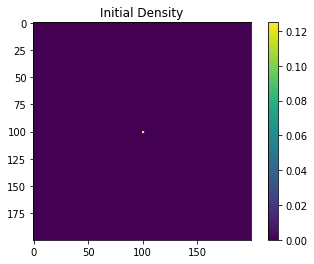

Motion of single particle:

Iteration: 0 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 1.30104261e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iteration: 1 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 2.60208521e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iteration: 2 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 3.90312782e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iteration: 3 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 5.20417043e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iteration: 4 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 6.50521303e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iteration: 5 Position [100. 100. 100.]
Velocity: [0.00000000e+00 0.00000000e+00 7.80625564e-19]
Acceleration: [ 1.73472348e-18 -4.33680869e-19 -6.07153217e-18]

Iterat

In [315]:
#Single Particle (should not move)
#length of grid cell = 1
rho=np.zeros([n,n,n])
m=1
dt=0.1

#Initialize at center of box
pos=np.asarray([n/2.0,n/2.0,n/2.0])
vel=np.asarray([0.0,0.0,0.0])

rho=positiontorho(pos,m,n,1)

#Plot density in x-y cross-section to make sure it makes sense
plt.figure('Initial Density')
plt.title('Initial Density')
plt.imshow(rho[:,:,n//2])
plt.colorbar()
plt.show()

#Loop parameters
niter=10
ndim=3
npart=1

print('Motion of single particle:')
for i in range(niter):
    pot=convolve_padded(rho,Gft)
    pos,vel,rho=leapfrog(pos,vel,pot,n,npart,m,dt)

    print('\nIteration:',i,'Position',pos)
    print('Velocity:',vel)
    print("Acceleration:",accel)


Position does not change and both acceleration and velocity stay at essentially 0. Good sign!

Part 2: 2 Particles in Orbit (hopefully)

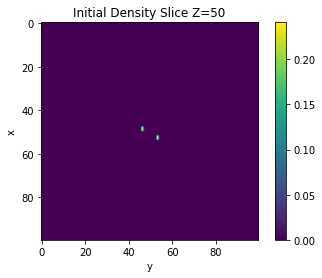

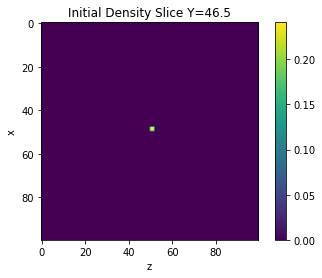

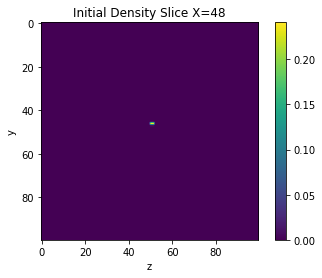

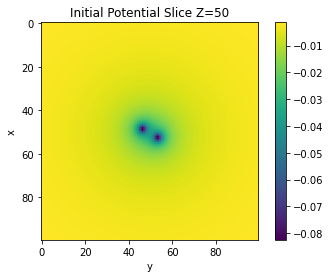

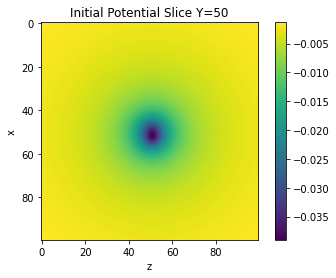

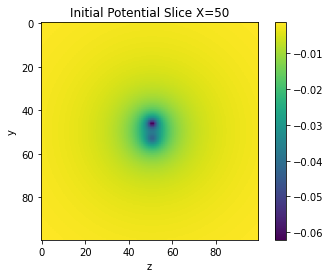

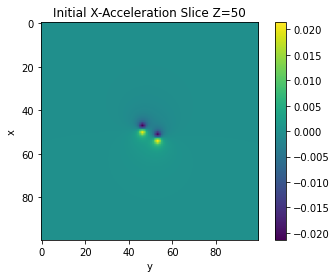

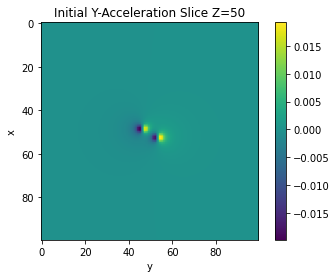

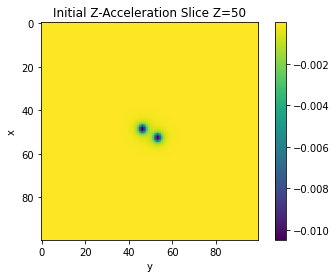

In [540]:
#2 particles in circular orbits
npart=2

r=4
v=5
theta=np.pi/3#np.random.rand()*2*np.pi

#Positions equidistant from center of mass (which is between them since they have the same mass)
pos2=np.asarray([[n/2-r*np.cos(theta),n/2-r*np.sin(theta),n/2],[(n/2+r*np.cos(theta)),(n/2+r*np.sin(theta)),n/2]])
#Velocities equal and opposite, and perpendicular to radial direction. 
vel2=np.asarray([[v*np.sin(theta),-v*np.cos(theta),0.0],[-v*np.sin(theta),v*np.cos(theta),0.0]])
#Set acceleration = 0 to begin
accel2=vel2*0

#Calculate initial density and plot a slice to check
rho2=positiontorho(pos2,m,n,npart)

plt.figure('Initial Density Z')
plt.title('Initial Density Slice Z=50')
plt.imshow(rho2[:,:,n//2])
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Density Y')
plt.title('Initial Density Slice Y=46.5')
plt.imshow(rho2[:,46,:])
plt.xlabel('z')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Density X')
plt.title('Initial Density Slice X=48')
plt.imshow(rho2[48,:,:])
plt.xlabel('z')
plt.ylabel('y')
plt.colorbar()
plt.show()

#Calculate and plot initial potential 
pot_init2=convolve_padded(rho2,Gft)

plt.figure('Initial Potential Z')
plt.title('Initial Potential Slice Z=50')
plt.imshow(pot_init2[:,:,n//2])
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Potential Y')
plt.title('Initial Potential Slice Y=50')
plt.imshow(pot_init2[:,n//2,:])
plt.xlabel('z')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Potential X')
plt.title('Initial Potential Slice X=50')
plt.imshow(pot_init2[n//2,:,:])
plt.xlabel('z')
plt.ylabel('y')
plt.colorbar()
plt.show()

#Calculate and plot initial acceleration/force (since m=1)
ax_init2,ay_init2,az_init2=np.gradient(pot_init2)

plt.figure('Initial Acceleration X')
plt.title('Initial X-Acceleration Slice Z=50')
plt.imshow(ax_init2[:,:,n//2])
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Acceleration Y')
plt.title('Initial Y-Acceleration Slice Z=50')
plt.imshow(ay_init2[:,:,n//2])
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure('Initial Acceleration Z')
plt.title('Initial Z-Acceleration Slice Z=50')
plt.imshow(az_init2[:,:,n//2])
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()



In [541]:
%%time 
niter=100

#Set timestep - must remain fixed for leapfrog
dt=0.1

#Specify where images will be saved
dir2="C:\\Users\\Owner\\Documents\\Fall2020\\Computational\\Notebooks\\2part\\"

for i in range(niter):
    pot2=convolve_padded(rho2,Gft)
    
    #Calculate initial energy
    if i==0:
         kinetic1=np.sum(0.5*m*np.sum(vel2**2,axis=1))
         potential1=np.sum(m*np.abs(pot2))
         Etot1=kinetic1+potential1
         print('\nInitial total energy is',Etot1)
         print('Kinetic:',kinetic1,'Potential:',potential1)
        
    #Update position and velocity using leapfrog method
    pos2,vel2,rho2=leapfrog(pos2,vel2,pot2,n,npart,m,dt)

    #Watch orbital radius over simulation - should remain close to constant
    #Not working - radius is increasing. The acceleration does not make sense- very small and direction changes over first few steps. 
    rnew1=np.sqrt(np.sum((pos2[0,:]-n/2)**2))
    rnew2=np.sqrt(np.sum((pos2[1,:]-n/2)**2))    
    print('\nOrbital radii',rnew1,rnew2)


    #Plot and save particle positions over time
    print('Plotting iteration', i)
    fig=plt.figure(figsize=(10,10))
    try: ax=fig.add_subplot(111,projection="3d")
    except : ax=Axes3D(fig) 
    ax.scatter(pos2[:,0],pos2[:,1],pos2[:,2],color="royalblue",marker=".")
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title("2 Particles\n",fontsize=20)
    ax.set_xlim3d(0,n)
    ax.set_ylim3d(0,n)
    ax.set_zlim3d(0,n)
    plt.savefig(dir2+'orbit'+repr(i)+'.png')
    plt.close();

#Calculate and print final energy 
kinetic2=np.sum(0.5*m*np.sum(vel2**2,axis=1))
potential2=np.sum(np.abs(pot2))
Etot2=kinetic2+potential2
print('\nTotal energy is',Etot2)
print('Kinetic:',kinetic2,'Potential:',potential2)

print('\nTotal energy was',Etot1)
print('Kinetic:',kinetic1,'Potential:',potential1)



Initial total energy is 2887.6591881914937
Kinetic: 25.0 Potential: 2862.6591881914937

Orbital radii 4.031122852567374 4.031122852567374
Plotting iteration 0

Orbital radii 4.123086514251831 4.123097243395253
Plotting iteration 1

Orbital radii 4.2720066599968405 4.271934521809467
Plotting iteration 2

Orbital radii 4.472129351767715 4.4718988058562195
Plotting iteration 3

Orbital radii 4.71686811480915 4.716516944921655
Plotting iteration 4

Orbital radii 4.999722635373935 4.999248354922192
Plotting iteration 5

Orbital radii 5.314638602042078 5.313943473172358
Plotting iteration 6

Orbital radii 5.656200013030189 5.655204576356019
Plotting iteration 7

Orbital radii 6.019822994341506 6.018528411423839
Plotting iteration 8

Orbital radii 6.401807333128324 6.40020543455466
Plotting iteration 9

Orbital radii 6.799056737138876 6.797090133047759
Plotting iteration 10

Orbital radii 7.208959575078658 7.206602615022294
Plotting iteration 11

Orbital radii 7.629416304249009 7.62672371874

The particles are not orbiting each other and I do not know why. As you can see above, the intial density, potential, and acceleration are in the right places and, in the case of acceleration, have the right orientation (at first). I believe the problem is with the magnitude of the acceleration (which is very small) but I don't know the root cause of that. 

Part 3: Periodic and Non-Periodic Boundary Conditions

In [336]:
%%time
def update(pos,vel,pot,dt,n,m,ndim,npart,periodic=True):
    pos,vel,rho=leapfrog(pos,vel,pot,n,npart,m,dt)
    
    for i in range(ndim):
        if periodic==True:
            for j in range(npart-1):
                #If particle leaves box, send it to other end. 
                if pos[j,i]<0: 
                    pos[j,i]+=n-1 
                if pos[j,i]>=(n-1):
                    pos[j,i]=pos[j,i]-n+1
        if periodic==False:
            for j in range(npart-1):
                if pos[j,i]<0 or pos[j,i]>=(n-1): 
                    pos=np.delete(pos,j,0)  
                    vel=np.delete(vel,j,0)
                    npart=npart-len(index)
                    print('Particle',j,'removed.')   
                    print('Number of particles updated to ',npart)
        
    return pos,vel,npart,rho

#Simulate lots of particles with periodic boundary conditions
dirn="C:\\Users\\Owner\\Documents\\Fall2020\\Computational\\Notebooks\\npart\\"

npart=300000

pos_n=np.random.rand(npart,ndim)*(n-2)
vel_n=np.zeros([npart,ndim])

ndim=len(pos_n[0])
npart=len(pos_n)

rho_n=positiontorho(pos_n,m,n,npart)

niter=3000
dt=0.05

showsteps=True
stepsize=5

for i in range(niter):
    pot_n=convolve_padded(rho_n,Gft)

    if i==0: #Calculate initial energy
        kinetic1=np.sum(0.5*m*np.sum(vel_n**2,axis=1))
        potential1=np.sum(m*np.abs(pot_n))
        Etot1=kinetic1+potential1
        print('Total energy is',Etot1)
        print('Kinetic:',kinetic1,'Potential:',potential1)

    pos_n,vel_n,npart,rho_n=update(pos_n,vel_n,pot_n,dt,n,m,ndim,npart,periodic=True)

    if showsteps==True and i%stepsize==0 or i==(niter-1):
        print('Plotting iteration', i)
        fig=plt.figure(figsize=(10,10))
        try: ax=fig.add_subplot(111,projection="3d")
        except: ax=Axes3D(fig) 
        ax.scatter(pos_n[:,0],pos_n[:,1],pos_n[:,2],color="royalblue",marker=".",s=.2)
        ax.set_xlabel("x-coordinate",fontsize=14)
        ax.set_ylabel("y-coordinate",fontsize=14)
        ax.set_zlabel("z-coordinate",fontsize=14)
        ax.set_title(repr(n)+"Particles\n",fontsize=20)
        ax.set_xlim3d(0,n)
        ax.set_ylim3d(0,n)
        ax.set_zlim3d(0,n)
        plt.savefig(dirn+'orbit'+repr(i)+'.png')
        print('Plot', i, 'saved.')
        plt.close();

#Final energy
kinetic2=np.sum(0.5*m*np.sum(vel_n**2,axis=1))
potential2=np.sum(m*np.abs(pot_n))
Etot2=kinetic2+potential2
print('\nTotal energy is',Etot2)
print('Kinetic:',kinetic2,'Potential:',potential2)
print('\nTotal energy was',Etot1)
print('Kinetic:',kinetic1,'Potential:',potential1)


saved.
Plotting iteration 570
Plot 570 saved.
Plotting iteration 575
Plot 575 saved.
Plotting iteration 580
Plot 580 saved.
Plotting iteration 585
Plot 585 saved.
Plotting iteration 590
Plot 590 saved.
Plotting iteration 595
Plot 595 saved.
Plotting iteration 600
Plot 600 saved.
Plotting iteration 605
Plot 605 saved.
Plotting iteration 610
Plot 610 saved.
Plotting iteration 615
Plot 615 saved.
Plotting iteration 620
Plot 620 saved.
Plotting iteration 625
Plot 625 saved.
Plotting iteration 630
Plot 630 saved.
Plotting iteration 635
Plot 635 saved.
Plotting iteration 640
Plot 640 saved.
Plotting iteration 645
Plot 645 saved.
Plotting iteration 650
Plot 650 saved.
Plotting iteration 655
Plot 655 saved.
Plotting iteration 660
Plot 660 saved.
Plotting iteration 665
Plot 665 saved.
Plotting iteration 670
Plot 670 saved.
Plotting iteration 675
Plot 675 saved.
Plotting iteration 680
Plot 680 saved.
Plotting iteration 685
Plot 685 saved.
Plotting iteration 690
Plot 690 saved.
Plotting iteration

Energy is not being conserved well - both kinetic and potential increased over simulation - and the particles are not behaving as I would expect them to for periodic BCs. They should be clustering in groups and spreading out rather than converging toward the center and then bouncing back out as they are. This is likely due to the same problem that is causing the two particles above to fly apart but after a lot of troubleshooting and I still cannot find the error, so this is what it has to be. 

In [558]:
%%time

def update(pos,vel,pot,dt,n,m,ndim,npart,periodic=True):
    #Rewrite update function because it didn't work for non-periodic BCs
    pos,vel,rho=leapfrog(pos,vel,pot,n,npart,m,dt)    

    for i in range(ndim):
        change=0
        if periodic==True:
            for j in range(npart-1):
                if pos[j,i]<0:
                    pos[j,i]+=n-1
                if pos[j,i]>=(n-1):
                    pos[j,i]=pos[j,i]-n+1
        if periodic==False:
            for j in range(npart):
                if pos[j,i]<0:
                    #If particles leave the box, delete them
                    pos=np.delete(pos,j,0)  
                    vel=np.delete(vel,j,0)
                    npart=npart-1
                    change=1
                if pos[j,i]>=(n-2): #do n-2 as boundary as a 'safety measure' because n-1 is missing some 
                    pos=np.delete(pos,j,0)  
                    vel=np.delete(vel,j,0)
                    npart=npart-1
                    change=1
                if j==(npart-1): #break out of loop if updated number of particles matches next loop index 
                    break 

        if change==1: 
            print('Number of particles updated to ',npart)

    return pos,vel,npart,rho

#Lots of particles with non-periodic boundary conditions
dirnp="C:\\Users\\Owner\\Documents\\Fall2020\\Computational\\Notebooks\\npart_nonperiodic_final\\" 

ndim=3
npart=300000 

pos_np=np.random.rand(npart,ndim)*(n-1)
vel_np=np.zeros([npart,ndim])

rho_np=positiontorho(pos_np,m,n,npart)

niter=1000 #1000 iterations to save computation time
dt=0.05

showsteps=True
stepsize=5

for i in range(niter):
    pot_np=convolve_padded(rho_np,Gft)

    # Initial Energy
    if i==0:
        kinetic1_np=np.sum(0.5*m*np.sum(vel_np**2,axis=1))
        potential1_np=np.sum(m*np.abs(pot_np))
        Etot1_np=kinetic1_np+potential1_np
        print('Total energy is',Etot1_np)
        print('Kinetic:',kinetic1_np,'Potential:',potential1_np)

    pos_np,vel_np,npart,rho_np=update(pos_np,vel_np,pot_np,dt,n,m,ndim,npart,periodic=False)

    if showsteps==True and i%stepsize==0:
        print('\nPlotting iteration', i)
        fig=plt.figure(figsize=(10,10)) #Create 3D axes
        try: ax=fig.add_subplot(111,projection="3d")
        except: ax=Axes3D(fig) 
        ax.scatter(pos_np[:,0],pos_np[:,1],pos_np[:,2],color="royalblue",marker=".",s=.2)
        ax.set_xlabel("x-coordinate",fontsize=14)
        ax.set_ylabel("y-coordinate",fontsize=14)
        ax.set_zlabel("z-coordinate",fontsize=14)
        ax.set_title(repr(n)+"Particles\n",fontsize=20)
        ax.set_xlim3d(0,n)
        ax.set_ylim3d(0,n)
        ax.set_zlim3d(0,n)
        plt.savefig(dirnp+'orbit'+repr(i)+'.png')
        print('Plot', i, 'saved.')
        plt.close();

#Final Energy
kinetic2_np=get_kinetic(m,vel_np)
potential2_np=np.sum(np.abs(pot_np))
Etot2_np=kinetic2_np+potential2_np
print('\nTotal energy is',Etot2_np)
print('Kinetic:',kinetic2_np,'Potential:',potential2_np)

print('\nTotal energy was',Etot1_np)
print('Kinetic:',kinetic1_np,'Potential:',potential1_np)

ated to  267329
Number of particles updated to  267325
Number of particles updated to  267324
Number of particles updated to  267322

Plotting iteration 715
Plot 715 saved.
Number of particles updated to  267320
Number of particles updated to  267319
Number of particles updated to  267318
Number of particles updated to  267316
Number of particles updated to  267314
Number of particles updated to  267313
Number of particles updated to  267312
Number of particles updated to  267305
Number of particles updated to  267302
Number of particles updated to  267300
Number of particles updated to  267297
Number of particles updated to  267296
Number of particles updated to  267291
Number of particles updated to  267288
Number of particles updated to  267285

Plotting iteration 720
Plot 720 saved.
Number of particles updated to  267279
Number of particles updated to  267275
Number of particles updated to  267274
Number of particles updated to  267272
Number of particles updated to  267266
Number 

Energy is definitely not conserved for the non-periodic boundary conditions, but this makes sense since particles are leaving the simulation. The behaviour is not what I expect, since I expect the particles to cluster towards the middle of the frame slowly rather than moving in and then out again. It's behaving a lot like the periodic boundary conditions situation, which is also very suspicious. 

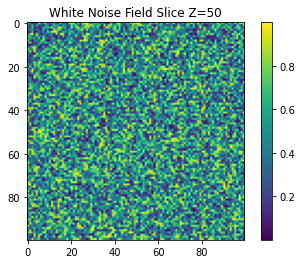

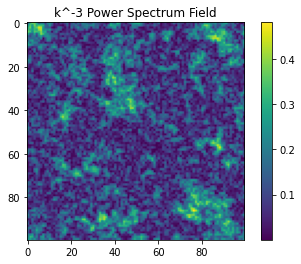

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
423329 particles kept in grid


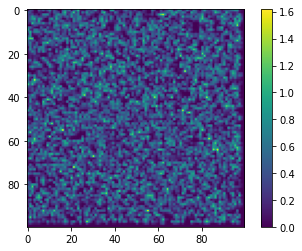

Total energy is 28537929.799727574
Kinetic: 0.0 Potential: 28537929.799727574
Plotting iteration 0
Plot 0 saved.
Plotting iteration 5
Plot 5 saved.
Plotting iteration 10
Plot 10 saved.
Plotting iteration 15
Plot 15 saved.
Plotting iteration 20
Plot 20 saved.
Plotting iteration 25
Plot 25 saved.
Plotting iteration 30
Plot 30 saved.
Plotting iteration 35
Plot 35 saved.
Plotting iteration 40
Plot 40 saved.
Plotting iteration 45
Plot 45 saved.
Plotting iteration 50
Plot 50 saved.
Plotting iteration 55
Plot 55 saved.
Plotting iteration 60
Plot 60 saved.
Plotting iteration 65
Plot 65 saved.
Plotting iteration 70
Plot 70 saved.
Plotting iteration 75
Plot 75 saved.
Plotting iteration 80
Plot 80 saved.
Plotting iteration 85
Plot 85 saved.
Plotting iteration 90
Plot 90 saved.
Plotting iteration 95
Plot 95 saved.
Plotting iteration 100
Plot 100 saved.
Plotting iteration 105
Plot 105 saved.
Plotting iteration 110
Plot 110 saved.
Plotting iteration 115
Plot 115 saved.
Plotting iteration 120
Plot 12

<Figure size 432x288 with 0 Axes>

In [561]:
%%time
import numpy

dirm="C:\\Users\\Owner\\Documents\\Fall2020\\Computational\\Notebooks\\npart_mass\\"

n=100

#Generate white noise field
white=np.random.rand(n,n,n)
whiteft=np.fft.fftn(white)

#Generate k vector to get power spectrum
kvec=np.arange(n)
kvec[n//2:]=kvec[n//2:]-n
kvec=kvec*2*np.pi/n
kx,ky,kz=np.meshgrid(kvec,kvec,kvec)
k=np.sqrt(kx**2+ky**2+kz**2)
k[0,0,0]=1000 #to avoid errors in power spectrum
#Calculate square root of power spectrum
sqrt_powerspec=np.sqrt(k**-3)
sqrt_powerspec[0,0,0]=0 #to make sure it doesn't go crazy at the center

#Convolve power spectrum and white field to get mass distribution
realization=np.fft.ifftn(np.multiply(whiteft,sqrt_powerspec))
realization=np.abs(realization)

plt.title('White Noise Field Slice Z=50')
plt.imshow(white[:,:,n//2])
plt.colorbar()
plt.show()

plt.title('k^-3 Power Spectrum Field')
plt.imshow(realization[:,:,n//2])
plt.colorbar()
plt.show()


npart=500000
ndim=3

pos_m=np.random.rand(npart,ndim)*(n-2)
#generate probability of being kept for each probability
keep=np.random.rand(npart)*realization.max() #multiply by realization maximum so they are distributed over same range

xm=pos_m[:,0]
ym=pos_m[:,1]
zm=pos_m[:,2]

for l in range(npart-1):
    i=np.int(np.floor(xm[l]))
    j=np.int(np.floor(ym[l]))
    k=np.int(np.floor(zm[l]))

    #Compare mass distribution to probability of keeping particle and get rid of particles that don't match distribution. 
    if realization[i,j,k]>=keep[l]:
        pos_m=np.delete(pos_m,l,0)
        npart=npart-1
    
    if l==(npart-1): break
    
    if l%10000==0: print(l) #track how far the comparison is

print(npart,'particles kept in grid')

vel_m=np.zeros([npart,ndim])

rho_m=positiontorho(pos_m,m,n,npart)

#Plot density to compare to power spectrum 
#Doesn't quite match but hopefully that's just because I'm not using enough points. 
plt.imshow(rho_m[:,:,n//2])
plt.colorbar()
plt.show()
plt.savefig('PowerInvariantDensity.png')

niter=1000
dt=0.05

showsteps=True
stepsize=5

for i in range(niter):
    pot_m=convolve_padded(rho_m,Gft)/(4*np.pi)

    #Initial Energy
    if i==0:
        kinetic1=get_kinetic(m,vel_m)
        potential1=np.sum(np.abs(pot_m))
        Etot1=kinetic1+potential1
        print('Total energy is',Etot1)
        print('Kinetic:',kinetic1,'Potential:',potential1)

    pos_m,vel_m,npart,rho_m=update(pos_m,vel_m,pot_m,dt,n,m,ndim,npart,periodic=True)

    if showsteps==True and i%stepsize==0 or i==(niter-1):
        print('Plotting iteration', i)
        fig=plt.figure(figsize=(10,10))
        try: ax=fig.add_subplot(111,projection="3d")
        except: ax=Axes3D(fig) 
        ax.scatter(pos_m[:,0],pos_m[:,1],pos_m[:,2],color="royalblue",marker=".",s=.2)
        ax.set_xlabel("x-coordinate",fontsize=14)
        ax.set_ylabel("y-coordinate",fontsize=14)
        ax.set_zlabel("z-coordinate",fontsize=14)
        ax.set_title(repr(n)+"Particles\n",fontsize=20)
        ax.set_xlim3d(0,n)
        ax.set_ylim3d(0,n)
        ax.set_zlim3d(0,n)
        plt.savefig(dirm+'orbit'+repr(i)+'.png')
        print('Plot', i, 'saved.')
        plt.close();

#Final energy
kinetic2=get_kinetic(m,vel_m)
potential2=np.sum(np.abs(pot_m))
Etot2=kinetic2+potential2
print('Total energy is',Etot2)
print('Kinetic:',kinetic2,'Potential:',potential2)
print('Total energy was',Etot1)
print('Kinetic:',kinetic1,'Potential:',potential1)

The particle distribution does not look as similar to the density field as anticipated and the density field magnitude does not reach one, which is suspicious. Hopefully the first effect is just a result of not using enough particles (but using more particles takes significantly longer to run) . The behavior looks almost identical to the earlier runs and seems to have the same problems with the periodic boundary conditions as the earlier simulation. 

In [572]:
import imageio
from pathlib import Path
from pygifsicle import optimize

#2 Particles as GIF
image_path = Path('2part')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))

imageio.mimwrite('2_particle_orbit.gif', image_list,loop=1,fps=2)

#Periodic BCs as GIF
image_path2 = Path('npart')
images2 = list(image_path2.glob('*.png'))
image_list2 = []
for file_name in images2:
    image_list2.append(imageio.imread(file_name))

imageio.mimwrite('n_particle_periodic.gif', image_list2,loop=1,fps=2)

#Non-periodic BCs as GIF
image_path3 = Path('npart_nonperiodic_final')
images3 = list(image_path3.glob('*.png'))
image_list3 = []
for file_name in images3:
    image_list3.append(imageio.imread(file_name))

imageio.mimwrite('n_particle_nonperiodic.gif', image_list3,loop=1,fps=2)

#Mass Distribution as GIF
image_path4 = Path('npart_mass')
images4 = list(image_path4.glob('*.png'))
image_list4 = []
for file_name in images4:
    image_list4.append(imageio.imread(file_name))

imageio.mimwrite('n_particle_mass.gif', image_list4,loop=1,fps=2)

